In [1]:
import pandas as pd 
import geopandas as gp
import altair as alt 
import gpdvega 
import json
import matplotlib.pyplot as plt
alt.renderers.enable('notebook') # render for Jupyter Notebook

DATA_DIR = '/nas/dft/ire/stuartlynn/MTA_ACCESSIBILITY/MTAAlertScraper-master/data/'

In [10]:
elevators = pd.read_csv(DATA_DIR+'EE_master_list.csv')
elevators = elevators[ (elevators.equipment_type == 'EL') & (elevators.ada_compliant == 'Y') ]
elevators.head(25)

In [11]:
mapped_elevators = pd.read_csv('/nas/dft/ire/pburka/dataclinic2019q4/elevator_to_line_dir_station.csv')
mapped_elevators.head()

In [12]:
elevators = elevators.set_index('equipment_id').join(mapped_elevators[['equipment_id', 'line', 'direction']].set_index('equipment_id'), how='left', rsuffix='_r')
elevators.reset_index(inplace=True)
elevators.head()

In [13]:
mezz_re = '.*([Mm]ezzanine|[Bb]alcony).*'
mezz = elevators[elevators.description.str.match(mezz_re)].station_name.unique()
no_mezz = elevators[~elevators.description.str.match(mezz_re)].station_name.unique()
len(mezz), len(no_mezz), len(set(mezz).intersection(set(no_mezz)))

(68, 36, 10)

In [16]:
import re

def elevator_route(desc):
    def simplify(name):
        if re.match(r'.*(St|Av|Plaza|Blvd|Park).*', name):
            return 'Street'
        if re.match(r'.*Upper Mezzanine.*', name):
            return 'Upper Mezzanine'
        if re.match(r'.*Lower Mezzanine.*', name):
            return 'Lower Mezzanine'
        if re.match(r'.*(Mezzanine|[Bb]alcony).*', name):
            return 'Mezzanine'
        if re.match(r'.*Platform.*', name):
            return 'Platform'
        return None

    m = re.search(r'^(.*?) (to|and|for) (.*)$', desc)
    if m:
        return simplify(m.group(1)), simplify(m.group(3))

    if re.match('^Mezzanine .*bound Platform$', desc):
        return ('Mezzanine', 'Platform')
    
    return (None, None)

assert elevator_route('125 St & Lexington Ave to Mezzanine for service in both directions') == ('Street', 'Mezzanine')
assert elevator_route('Mezzanine to Platform for downtown A/C service') == ('Mezzanine', 'Platform')
assert elevator_route('Mezzanine to Platforms for service in both directions') == ('Mezzanine', 'Platform')
assert elevator_route('Mezzanine to uptown Platform') == ('Mezzanine', 'Platform')
assert elevator_route('161 St & River Ave (NE Corner) to Mezzanine to reach service in both directions') == ('Street', 'Mezzanine')

elevators['elev_from'] = elevators.description.apply(lambda d : elevator_route(d)[0])
elevators['elev_to'] = elevators.description.apply(lambda d : elevator_route(d)[1])
elevators.head()



In [19]:
def make_name(t):
    label, station, line, direction = t
    if label == None:
        return None
    if label == 'Platform':
        return '-'.join([str(x) for x in [label, station, line, direction]])
    return '-'.join([str(x) for x in [label, station]])

elevators['canon_elev_from'] = elevators[['elev_from', 'station_name', 'line', 'direction_r']].apply(make_name, axis=1)
elevators['canon_elev_to'] = elevators[['elev_to', 'station_name', 'line', 'direction_r']].apply(make_name, axis=1)
elevators.head()

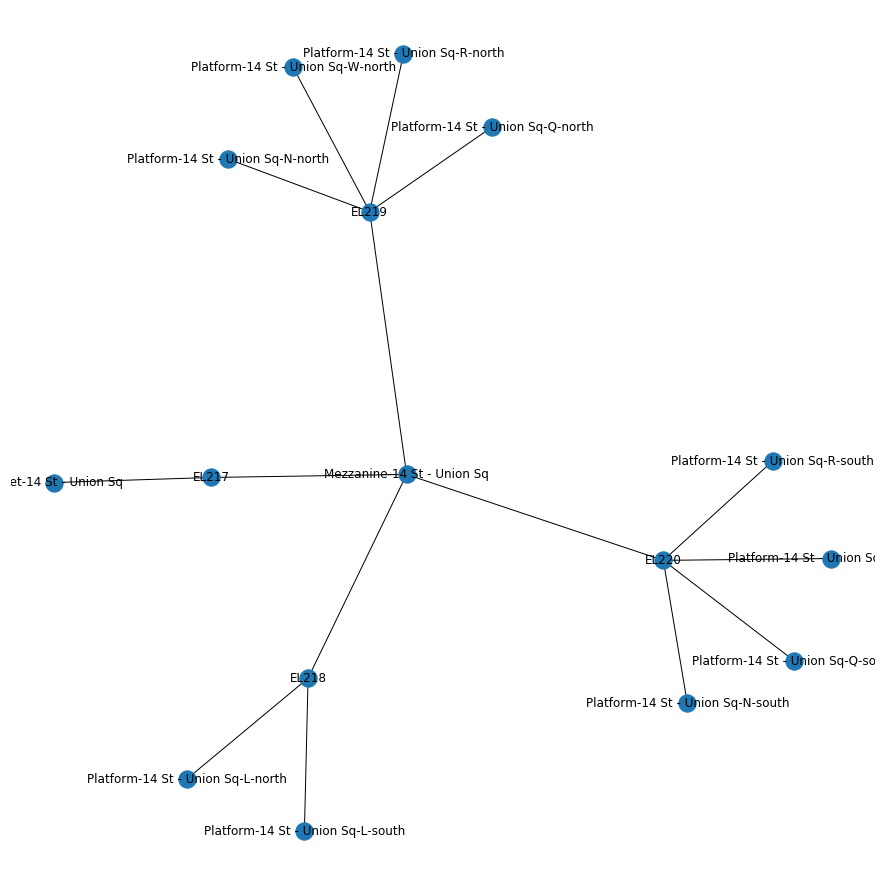

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
for _, row in elevators[elevators.station_name == '14 St - Union Sq'].iterrows():
    g.add_node(row['equipment_id'], label=row['equipment_id'])
    g.add_node(row['canon_elev_from'], label=row['canon_elev_from'])
    g.add_node(row['canon_elev_to'], label=row['canon_elev_to'])
    g.add_edge(row['canon_elev_from'], row['equipment_id'])
    g.add_edge(row['equipment_id'], row['canon_elev_to'])

labels={node : attrs['label'] for node, attrs in g.nodes(True)}    

plt.figure(figsize=(12,12)) 
nx.draw(g, with_labels=True, labels=labels)


In [138]:
mapped_elevators = pd.read_csv('/nas/dft/ire/pburka/dataclinic2019q4/elevator_to_line_dir_station.csv')
mapped_elevators.head()

In [151]:
merged = elevators.set_index('equipment_id').join(mapped_elevators[['equipment_id', 'line', 'direction']].set_index('equipment_id'), how='left', rsuffix='_r')
merged.head()